# Aufgabe 13: How to train a Deep Q Network
01.02.2022, Thomas Iten

**Content**
1. Setup
2. DQN
3. Memory (Experience, ReplayBuffer, RLDataset)
4. Agent
5. DQN Lightning Module
6. Trainer
7. Test Score
8. Visualize the game

**References**
- https://github.com/gsurma/cartpole
- https://github.com/openai/gym/wiki/Leaderboard
- https://colab.research.google.com/drive/1cBfKCEsLcj1ppXfqRvvgoranbxj0C6a9#scrollTo=b0dc7a72
- https://colab.research.google.com/drive/1tlbupNEh_MJwYrJZM8FZpJcsKX7GObRj
- https://colab.research.google.com/drive/1PY5a-NqvjFxnK_Bq4empyT4GQSNKk9lE?usp=sharing
- https://colab.research.google.com/drive/1lsDRQYs87b7BHkSw6BD4m6WMNZS_48i6?usp=sharing


# 1. Setup

In [57]:
# ! pip install --quiet "torch>=1.6, <1.9" "pytorch-lightning>=1.3" "gym" "torchmetrics>=0.3"

In [58]:
import os
from collections import OrderedDict, deque, namedtuple
from typing import List, Tuple

import gym
import numpy as np
import torch
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.utilities import DistributedType
from torch import Tensor, nn
from torch.optim import Adam, Optimizer
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
AVAIL_GPUS = min(1, torch.cuda.device_count())


# 2. DQN

Wir haben 2 Instanzen vom DQN:
- DQN versucht Q-Value zu verbessern. Dass heisst ist supervised, muss lernen können.
- Ein Netzwerk wird dauernd trainiert mit Target von zweiten Netzwerk, dass nicht trainiert wird.

Idee:
- Es wird ein zweites Netzwerk definiert, dass nicht trainiert wird,
  sondern mit den Gwichten von ersten Netzwerk aktualisiert wird (sync_rate).
- Aufgabe vom 2ten Netzwerk ist Target zu generieren. Target ist Next State
- Das erste Netzwerk wird mit dem Next State vom 2ten Netzwerk angepasst.


In [59]:
class DQN(nn.Module):
    """Simple MLP network."""

    def __init__(self, obs_size: int, n_actions: int, hidden_size=24):
        """
            obs_size: observation/state size of the environment
            n_actions: number of discrete actions available in the environment
            hidden_size: size of hidden layers
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions),
        )

    def forward(self, x):
        return self.net(x.float())

# 3. Memory

## Experience

In [60]:

# Named tuple for storing experience steps gathered in training
Experience = namedtuple(
    "Experience",
    field_names=["state", "action", "reward", "done", "new_state"],
)

## ReplayBuffer


In [61]:
class ReplayBuffer:
    """Replay Buffer for storing past experiences allowing the agent to learn from them.

    Args:
        capacity: size of the buffer
    """

    def __init__(self, capacity: int) -> None:
        self.buffer = deque(maxlen=capacity)

    def __len__(self) -> None:
        return len(self.buffer)

    def append(self, experience: Experience) -> None:
        """Add experience to the buffer.

        Args:
            experience: tuple (state, action, reward, done, new_state)
        """
        self.buffer.append(experience)

    def sample(self, batch_size: int) -> Tuple:
        # Samplel indices batch_size indicies
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, dones, next_states = zip(*(self.buffer[idx] for idx in indices))

        return (
            np.array(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(dones, dtype=np.bool),
            np.array(next_states),
        )


## RLDataset

Buffer wird in RLDataset gewrappt. Man iteriert, aber jedesmal wird gesampelt!

In [62]:
class RLDataset(IterableDataset):
    """Iterable Dataset containing the ExperienceBuffer which will be updated with new experiences
    during training.
    """

    def __init__(self, buffer: ReplayBuffer, sample_size: int = 200) -> None:
        self.buffer = buffer
        self.sample_size = sample_size

    def __iter__(self):
        states, actions, rewards, dones, new_states = self.buffer.sample(self.sample_size)
        for i in range(len(dones)):
            yield states[i], actions[i], rewards[i], dones[i], new_states[i]

# 4. Agent

In [63]:
class Agent:
    """Base Agent class handeling the interaction with the environment."""

    def __init__(self, env: gym.Env, replay_buffer: ReplayBuffer) -> None:
        """
        Args:
            env: training environment
            replay_buffer: replay buffer storing experiences
        """
        self.env = env
        self.replay_buffer = replay_buffer
        self.reset()

    def reset(self) -> None:
        """Resents the environment and updates the state."""
        self.state = self.env.reset()

    def get_action(self, net: nn.Module, epsilon: float, device: str) -> int:
        """Using the given network, decide what action to carry out using an epsilon-greedy policy.

        Args:
            net: DQN network
            epsilon: value to determine likelihood of taking a random action
            device: current device

        Returns:
            action
        """
        if np.random.random() < epsilon:
            action = self.env.action_space.sample()
        else:
            state = torch.tensor([self.state])

            if device not in ["cpu"]:
                state = state.cuda(device)

            q_values = net(state)                      # q_values (können auch > 1 sein)
            _, action = torch.max(q_values, dim=1)     # wir nehmen den grössten Wert
            action = int(action.item())

        return action

    @torch.no_grad()                    # Netwerk lernt nicht sondern gibt nur Resultate zurück
    def play_step(
            self,
            net: nn.Module,             # The DQN network
            epsilon: float = 0.0,       # value to determine likelihood of taking a random action
                                        # Set to 0 to play after the training
            device: str = "cpu",        # Current device
        ) -> Tuple[float, bool]:
        """Carries out a single interaction step between the agent and the environment.
        Returns:
            reward, done
        """
        action = self.get_action(net, epsilon, device)

        # do step in the environment
        new_state, reward, done, _ = self.env.step(action)
        exp = Experience(self.state, action, reward, done, new_state)
        self.replay_buffer.append(exp)
        self.state = new_state
        if done:
            self.reset()
        return reward, done

# 5. DQN Lightning Module

In [64]:
class DQNLightning(LightningModule):
    """Basic DQN Model."""

    def __init__(
        self,
        batch_size: int         = 20,               # size of the batches (Test mit 32)
        lr: float               = 0.001,            # learning rate
        env: str                = "CartPole-v0",    # gym environment tag
        gamma: float            = 0.95,             # discount factor
        sync_rate: int          = 20,               # Aktualisierung der Gewichte
        replay_size: int        = 1000000,          # capacity of the replay buffer (Test mit 10000)
        warm_start_size: int    = 1000000,          # number of samples to fill our buffer at the start (Test mit 10_000)
        eps_last_frame: int     = 1000,             # what frame should epsilon stop decaying (Test mit 100_000?)
        eps_start: float        = 1.0,              # starting value of epsilon
        eps_end: float          = 0.01,             # final value of epsilon
        episode_length: int     = 1000,             # max length of an episode (Test mit 400)
        warm_start_steps: int   = 1000000,          # max episode reward in the environment
    ) -> None:
        super().__init__()
        self.save_hyperparameters()

        self.env = gym.make(self.hparams.env)
        obs_size = self.env.observation_space.shape[0]
        n_actions = self.env.action_space.n

        self.net = DQN(obs_size, n_actions)         # online network (wird trainiert)
        self.target_net = DQN(obs_size, n_actions)  # target network

        self.buffer = ReplayBuffer(self.hparams.replay_size)
        self.agent = Agent(self.env, self.buffer)
        self.total_reward = 0
        self.episode_reward = 0
        self.populate(self.hparams.warm_start_steps)

    def populate(self, steps: int = 1000) -> None:
        """Carries out several random steps through the environment to initially
        fill up the replay buffer with experiences.

        Args:
            steps: number of random steps to populate the buffer with
        """
        for i in range(steps):
            self.agent.play_step(self.net, epsilon=1.0)

    def forward(self, x: Tensor) -> Tensor:
        """Passes in a state x through the network and gets the q_values of each action as an output.

        Args:
            x: environment state

        Returns:
            q values
        """
        output = self.net(x)
        return output               # Output sind Q-Values

    def dqn_mse_loss(self, batch: Tuple[Tensor, Tensor]) -> Tensor:
        """Calculates the mse loss using a mini batch from the replay buffer.
        Args:  batch: current mini batch of replay data
        Returns: loss
        """
        states, actions, rewards, dones, next_states = batch

        # q-values holen (current)
        state_action_values = self.net(states).gather(1, actions.type(torch.int64).unsqueeze(-1)).squeeze(-1)

        with torch.no_grad():
            # next holen aus targen
            next_state_values = self.target_net(next_states).max(1)[0]
            next_state_values[dones] = 0.0
            next_state_values = next_state_values.detach()

        # dito SARSA max: target = reward + (gamma * Qsa_next)
        expected_state_action_values = next_state_values * self.hparams.gamma + rewards

        return nn.MSELoss()(state_action_values, expected_state_action_values)

    def training_step(self, batch: Tuple[Tensor, Tensor], nb_batch) -> OrderedDict:
        """Carries out a single step through the environment to update the replay buffer.
        Then calculates loss based on the minibatch recieved.
        Args:
            batch: current mini batch of replay data
            nb_batch: batch number
        Returns:
            Training loss and log metrics
        """
        device = self.get_device(batch)
        epsilon = max(
            self.hparams.eps_end,
            self.hparams.eps_start - self.global_step + 1 / self.hparams.eps_last_frame,
        )

        # step through environment with agent
        reward, done = self.agent.play_step(self.net, epsilon, device)
        self.episode_reward += reward

        # calculates training loss
        loss = self.dqn_mse_loss(batch)

        # Bachward propagation step, done be lightning out of the box

        # Multi GPU Training
        if self.trainer._distrib_type in {DistributedType.DP, DistributedType.DDP2}:
            loss = loss.unsqueeze(0)

        if done:
            self.total_reward = self.episode_reward
            self.episode_reward = 0

        # Soft update of target network
        if self.global_step % self.hparams.sync_rate == 0:
            self.target_net.load_state_dict(self.net.state_dict())

        log = {
            "total_reward": torch.tensor(self.total_reward).to(device),
            "reward": torch.tensor(reward).to(device),
            "train_loss": loss,
        }
        status = {
            "steps": torch.tensor(self.global_step).to(device),
            "total_reward": torch.tensor(self.total_reward).to(device),
        }

        return OrderedDict({"loss": loss, "log": log, "progress_bar": status})

    def configure_optimizers(self) -> List[Optimizer]:
        """Initialize Adam optimizer."""
        optimizer = Adam(self.net.parameters(), lr=self.hparams.lr)
        return [optimizer]

    def __dataloader(self) -> DataLoader:
        """Initialize the Replay Buffer dataset used for retrieving experiences."""
        dataset = RLDataset(self.buffer, self.hparams.episode_length)
        dataloader = DataLoader(
            dataset=dataset,
            batch_size=self.hparams.batch_size,
        )
        return dataloader

    def train_dataloader(self) -> DataLoader:
        """Get train loader."""
        return self.__dataloader()

    def get_device(self, batch) -> str:
        """Retrieve device currently being used by minibatch."""
        return batch[0].device.index if self.on_gpu else "cpu"

# 6. Trainer

## Fit model

In [65]:
model = DQNLightning()

trainer = Trainer(
    gpus=AVAIL_GPUS,
    max_epochs=1000,
    val_check_interval=100,
)

trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name       | Type | Params
------------------------------------
0 | net        | DQN  | 770   
1 | target_net | DQN  | 770   
------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)
D:\dev\software\miniconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

D:\dev\software\miniconda3\lib\site-packages\pytorch_lightning\loops\optimization\closure.py:35: LightningDeprecationWarning: One of the returned values {'log', 'progress_bar'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  rank_zero_deprecation(


## Show Tensorboard (disabled)

Run in Terminal with:
```
tensorboard --logdir ligthning_logs
```

In [66]:
# %load_ext tensorboard
# %tensorboard --logdir lightning_logs/

# 7. Test Score

## Play a single game

In [67]:
def play_game():
    agent = model.agent
    agent.env.reset()
    score = 0
    for t in range(1000):
        score = t+1
        action, _  = agent.play_step(net=model.net, epsilon=0, device='cpu')
        state, reward, done, _ = agent.env.step(int(action))
        if done:
            break
    return score

score = play_game()
print("Score of a single game:")
print(score)

Score of a single game:
12


## Play n games

In [68]:
def play_games(n):
    total = 0
    for i in range(n):
        total += play_game()
    return total/n

n = 1000
avg_score = play_games(n)
print("Average score of " + str(n) + " games:")
print(avg_score)



Average score of 1000 games:
11.596


# 8. Visualize the game


In [69]:
import matplotlib.pyplot as plt

# Set plotting options
%matplotlib inline
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=120)

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display
plt.ion()


Score:  5


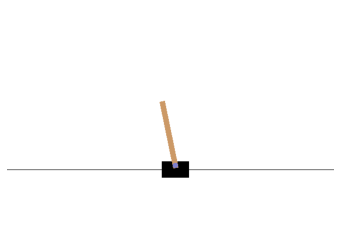

In [70]:
state = model.agent.env.reset()
img = plt.imshow(model.agent.env.render(mode='rgb_array'))
for t in range(1000):
    # step through environment with agent
    action,_ = model.agent.play_step(model.net, 0, 'cpu')
    #action = env.action_space.sample()
    img.set_data(model.agent.env.render(mode='rgb_array'))
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = model.agent.env.step(int(action))
    if done:
        print('Score: ', t+1)
        break

model.agent.env.close()


---
__The end.__